In [218]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
import pandas as pd
import joblib
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.image
from PIL import Image
import numpy as np


In [219]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.image

# Função para clarear a imagem
def clarear(imagem, fator):
    img_array = np.array(imagem)
    nova_imagem = np.clip(np.int32(imagem) + fator, 0, 255).astype(np.uint8)
    return nova_imagem

# Função para escurecer a imagem
def escurecer(imagem, fator):
    img_array = np.array(imagem)
    nova_imagem = nova_imagem = np.clip(np.int32(imagem) - fator, 0, 255).astype(np.uint8)
    return nova_imagem

def gama(img, gama, c):
  from PIL import Image
  import numpy as np

  img_n = (np.array(img).astype(np.int32))/255
  img_n = img_n ** gama
  img_n = img_n * 255
  img_n = np.clip(img_n*c, 0, 255)

  return img_n.astype(np.uint8)

def transformacao_log(img, c):
  from PIL import Image
  import numpy as np
  img = np.array(img).astype(np.int32)
  t_img = np.log1p(img)
  t_img = np.clip(t_img*c, 0, 255)

  return t_img.astype(np.uint8)

def equalizar_histograma(imagem):
    from PIL import Image
    import numpy as np

    img_array = np.array(imagem)
    hist, bins = np.histogram(img_array.flatten(), bins=256, range=(0, 255))
    cdf = hist.cumsum()
    cdf_normalizedo = (cdf - cdf.min())*255/(cdf.max() - cdf.min())
    #cdf_normalizedo = cdf * hist.max() / cdf.max()
    nova_imagem = np.interp(img_array.flatten(), np.arange(0, 256), cdf_normalizedo)
    #nova_imagem = np.interp(img_array.flatten(), bins[:-1], cdf_normalizedo)
    nova_imagem = nova_imagem.reshape(img_array.shape).astype(np.uint8)

    return nova_imagem



def suavizar_media(img, kernel):
    from PIL import Image
    import numpy as np
    img = np.array(img)
    if kernel % 2 == 0:
      kernel = kernel + 1

    h, l = img.shape

    kernel_2 = kernel // 2

    s_img = np.zeros_like(img, dtype=np.int32)

    for y in range(h):
      for x in range(l):
        y_min = max(0, y - kernel_2)
        y_max = min(h, y + kernel_2 + 1)
        x_min = max(0, x - kernel_2)
        x_max = min(l, x + kernel_2 + 1)

        k_s = img[y_min:y_max, x_min:x_max]

        s_pixel = np.mean(k_s)

        s_img[y, x] = s_pixel

    return s_img.astype(np.uint8)

def suavizar_mediana(img, kernel):
    from PIL import Image
    import numpy as np
    img = np.array(img)
    if kernel % 2 == 0:
      kernel = kernel + 1

    h, l = img.shape

    kernel_2 = kernel // 2

    s_img = np.zeros_like(img, dtype=np.int32)


    for y in range(h):
      for x in range(l):
        y_min = max(0, y - kernel_2)
        y_max = min(h, y + kernel_2 + 1)
        x_min = max(0, x - kernel_2)
        x_max = min(l, x + kernel_2 + 1)

        k_s = img[y_min:y_max, x_min:x_max]

        s_pixel = np.median(k_s)

        s_img[y, x] = s_pixel

    return s_img.astype(np.uint8)

def agucar_1(img, a):
    from PIL import Image
    import numpy as np

    img = np.array(img)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])

    img_a = np.convolve(img.flatten('C'), kernel.flatten('C'), mode='same').reshape(img.shape)

    img_a = np.int32(img) + a * (img_a - img)

    img_a = np.clip(img_a, 0, 255)

    return img_a.astype(np.uint8)

def detectar_bordas(imagem):
    from PIL import Image
    import numpy as np
    imagem = np.array(imagem)
    imagem_cinza = imagem


    filtro_horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    gradiente_horizontal = np.abs(np.convolve(imagem_cinza.flatten('C'), filtro_horizontal.flatten('C'), mode='same').reshape(imagem.shape))


    filtro_vertical = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    gradiente_vertical = np.abs(np.convolve(imagem_cinza.flatten('C'), filtro_vertical.flatten('C'), mode='same').reshape(imagem.shape))


    gradiente_total = np.sqrt(gradiente_horizontal**2 + gradiente_vertical**2)


    gradiente_normalizado = (gradiente_total / np.max(gradiente_total)) * 255
    #gradiente_normalizado = 255 - gradiente_normalizado

    return gradiente_normalizado.astype(np.uint8)

def agucar_2(imagem, a):
  from PIL import Image
  import numpy as np

  bordas = np.array(detectar_bordas(imagem))
  img = np.array(imagem)
  img_a = np.clip((np.int32(img) + a * np.int32(bordas)),0 ,255)

  return img_a.astype(np.uint8)

def agucar_3(img, a):
    from PIL import Image
    import numpy as np

    img = np.array(img)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])

    img_a = np.convolve(img.flatten('C'), kernel.flatten('C'), mode='same').reshape(img.shape)

    img_a = img_a + a * (img_a - img)

    img_a = np.clip(img_a, 0, 255)

    return img_a.astype(np.uint8)

#Filtro Passa Banda
def suavizar_f_passa_banda(img, fr, kind=0):
  import numpy as np
  from PIL import Image

  #Converte a imagem para numpy array
  img = np.array(img)

  #Realiza a tranformada de Fourier na imgagem (np.fft.fft2) e depois centraliza a imagem (np.fft.fftshift)
  img_t = np.fft.fftshift(np.fft.fft2(img))

  #Filtro Passa banda
  h, w = img.shape[0:2]
  #Kernel com as dimensões h e w da imagem original preenchidos com 1s próximo ao centro e 0s longe do centro
  # np.floor((w)/2) e np.floor((w)/2) encontram o centro da imagem
  # fr adiciona uma espessura horizontal e vertical
  # a ideia é criar uma cruz (+) na imagem, onde tudo dentro dessa região é preencido com 1 e tudo fora é preenchido com 0
  kernel = [[0 if (i >= np.floor((w)/2)+fr or i <= np.floor((w)/2)-fr)  and (j >= np.floor((h)/2)+fr or j <= np.floor((h)/2)-fr) else 1 for i in range (w)]for j in range(h)]

  #Multiplica a imagem transforada pelo kernel, anulando assim todas as informações fora da cruz (+) formada no kernel
  img_f = img_t * kernel

  #Retira a centralização (np.fft.ifftshift) da imagem fitrada (img_t * kernel) e depois realiza a transformada inversa na imagem (np.fft.ifft2)
  img_inv = np.fft.ifft2(np.fft.ifftshift(img_f))

  #Filtra apenas a parte real de cada pixel (np.real) e exclui os componentes imaginários na matriz
  #realce = img + r * np.real(img_inv)
  realce = np.real(img_inv)

  #Limita os valore da matriz realce a valores entre 0 e 255
  img_realce = np.clip(realce, 0, 255)

  #Escolhe o formato de saída da função.
  #Onde kind=1 retorna uma lista contendo a:
  #[0] imagem original (Image.fromarray(img))
  #[1] imagem no domínio da frequência - aplicação da transformada de Fourier na imagem original (Image.fromarray(img_t.astype(np.uint8))
  #[2] imagem no domínio da frequência com a aplicação do filtro (Image.fromarray(img_f.astype(np.uint8)))
  #[3] imagem final após a transformada inversa (Image.fromarray(img_realce.astype(np.uint8)))
  # Onde kind=0 retorna apenas a imagem final (default)
  if kind == 1:
    return [Image.fromarray(img), Image.fromarray(20*np.log(np.real(img_t)).astype(np.uint8)), Image.fromarray(20*np.log(np.real(img_f)).astype(np.uint8)), Image.fromarray(img_realce.astype(np.uint8))]
  elif kind == 0:
    return img_realce.astype(np.uint8)

#Suavizar Filtro Passa Baixa Ideal
def suavizar_f_passa_baixa_ideal(img, fr, kind=0):
  import numpy as np
  from PIL import Image

  #Converte a imagem para numpy array
  img = np.array(img)

  #Realiza a tranformada de Fourier na imgagem (np.fft.fft2) e depois centraliza a imagem (np.fft.fftshift)
  img_t = np.fft.fftshift(np.fft.fft2(img))

  #Filtro Passa Baixa ideal
  h, w = img.shape[0:2]
  #Kernel com as dimensões h e w da imagem original preenchidos com 1s próximo ao centro e 0s longe do centro
  # np.floor((w-1)/2) e np.floor((h-1)/2) encontram o centro da imagem
  # fr adiociona o raio com relação ao centro
  # a ideia é criar uma circunferência (o) na imagem, onde tudo dentro dessa região é preencido com 1 e tudo fora é preenchido com 0
  kernel = [[1 if ((((i-np.floor((w-1)/2))**2 + (j-np.floor((h-1)/2))**2)**(1/2)) <= fr) else 0 for i in range(w)]for j in range(h)]

  #Multiplica a imagem transforada pelo kernel, anulando assim todas as informações fora da cruz (+) formada no kernel
  img_f = img_t * kernel

  #Retira a centralização (np.fft.ifftshift) da imagem fitrada (img_t * kernel) e depois realiza a transformada inversa na imagem (np.fft.ifft2)
  img_inv = np.fft.ifft2(np.fft.ifftshift(img_f))

  #realce = img + r * np.real(img_inv)
  #Filtra apenas a parte real de cada pixel (np.real) e exclui os componentes imaginários na matriz
  realce = np.real(img_inv)

  #Limita os valore da matriz realce a valores entre 0 e 255
  img_realce = np.clip(realce, 0, 255)

  #Escolhe o formato de saída da função.
  #Onde kind=1 retorna uma lista contendo a:
  #[0] imagem original (Image.fromarray(img))
  #[1] imagem no domínio da frequência - aplicação da transformada de Fourier na imagem original (Image.fromarray(img_t.astype(np.uint8))
  #[2] imagem no domínio da frequência com a aplicação do filtro (Image.fromarray(img_f.astype(np.uint8)))
  #[3] imagem final após a transformada inversa (Image.fromarray(img_realce.astype(np.uint8)))
  # Onde kind=0 retorna apenas a imagem final (default)
  if kind == 1:
    return [Image.fromarray(img), Image.fromarray(np.log(np.abs(img_t)+1).astype(np.uint8)), Image.fromarray(np.log(np.abs(img_f)+1).astype(np.uint8)), Image.fromarray(img_realce.astype(np.uint8))]
  elif kind == 0:
    return img_realce.astype(np.uint8)

#Suavizar Filtro Passa Baixa de Butterworth
def suavizar_f_passa_baixa_B(img, fr, n, kind=0):
  import numpy as np
  from PIL import Image

  #Converte a imagem para numpy array
  img = np.array(img)

  #Realiza a tranformada de Fourier na imgagem (np.fft.fft2) e depois centraliza a imagem (np.fft.fftshift)
  img_t = np.fft.fftshift(np.fft.fft2(img))

  #Filtro Passa baixa de Butterworth
  h, w = img.shape[0:2]
  #Kernel com as dimensões h e w da imagem original
  # faz o cálculo da função de Butterworth com a função 1/(1+(fr/((i-(w-1)/2)**2 + (j-(h-1)/2)**2)**(1/2)))**(2*n)
  # usa 'if (np.abs(i-(w-1)/2) + np.abs(j-(h-1)/2)) != 0' para fugir da singularidade (divisão por 0) no centro da imagem
  # a ideia é criar uma circunferência (o) na imagem, onde quanto mais próximo do centro mais próximo a 0 e mais distante do centro mais próximo a 1
  # o n potencializa a variação dos números entre 0 e 1 de acordo com a distância para o centro
  kernel = [[1/(1+(fr/((i-(w-1)/2)**2 + (j-(h-1)/2)**2)**(1/2)))**(2*n) if (np.abs(i-(w-1)/2) + np.abs(j-(h-1)/2)) != 0 else 1 for i in range(w)]for j in range(h)]
  # inverte o kernel para aproximar de 1 os valores do centro de de 0 os valores distantes do centro
  kernel = 1 - np.array(kernel)

  #Multiplica a imagem transforada pelo kernel, anulando assim atenuando as informações longe do centro (0) formada no kernel
  img_f = img_t * kernel

  #Retira a centralização (np.fft.ifftshift) da imagem fitrada (img_t * kernel) e depois realiza a transformada inversa na imagem (np.fft.ifft2)
  img_inv = np.fft.ifft2(np.fft.ifftshift(img_f))

  #Filtra apenas a parte real de cada pixel (np.real) e exclui os componentes imaginários na matriz
  #realce = img + r * np.real(img_inv)
  realce = np.real(img_inv)

  #Limita os valore da matriz realce a valores entre 0 e 255
  img_realce = np.clip(realce, 0, 255)

  #Escolhe o formato de saída da função.
  #Onde kind=1 retorna uma lista contendo a:
  #[0] imagem original (Image.fromarray(img))
  #[1] imagem no domínio da frequência - aplicação da transformada de Fourier na imagem original (Image.fromarray(img_t.astype(np.uint8))
  #[2] imagem no domínio da frequência com a aplicação do filtro (Image.fromarray(img_f.astype(np.uint8)))
  #[3] imagem final após a transformada inversa (Image.fromarray(img_realce.astype(np.uint8)))
  # Onde kind=0 retorna apenas a imagem final (default)
  if kind == 1:
    return [Image.fromarray(img), Image.fromarray(np.log(np.abs(img_t)+1).astype(np.uint8)), Image.fromarray(np.log(np.abs(img_f)+1).astype(np.uint8)), Image.fromarray(img_realce.astype(np.uint8))]
  elif kind == 0:
    return img_realce.astype(np.uint8)

#Suavizar Filtro Passa Baixa Gaussiano
def suavizar_f_passa_baixa_G(img, sigma, kind=0):
  import numpy as np
  from PIL import Image

  #Converte a imagem para numpy array
  img = np.array(img)

  #Realiza a tranformada de Fourier na imgagem (np.fft.fft2) e depois centraliza a imagem (np.fft.fftshift)
  img_t = np.fft.fftshift(np.fft.fft2(img))

  #Filtro Passa Baixa Gaussiano
  h, w = img.shape[0:2]
  #Kernel com as dimensões h e w da imagem original
  # np.floor((w-1)/2) e np.floor((h-1)/2)) encontram o centro da imagem
  # faz o cálculo da função Gaussiana com a função '1-np.exp(-(((i-np.ceil((w-1)/2))**2 + (j-np.ceil((h-1)/2))**2))/(2*sigma**2)'
  # a ideia é criar uma circunferência (o) na imagem, onde quanto mais próximo do centro mais próximo a 0 e mais distante do centro mais próximo a 1
  # o sigma potencializa a variação dos números entre 0 e 1 de acordo com a distância para o centro
  kernel = [[1-np.exp(-(((i-np.floor((w-1)/2))**2 + (j-np.floor((h-1)/2))**2))/(2*sigma**2)) for i in range(w)]for j in range(h)]
  # inverte o kernel para aproximar de 1 os valores do centro de de 0 os valores distantes do centro
  kernel = 1 - np.array(kernel)

  #Multiplica a imagem transforada pelo kernel, anulando assim atenuando as informações longe do centro (o) formada no kernel
  img_f = img_t * kernel

  #Retira a centralização (np.fft.ifftshift) da imagem fitrada (img_t * kernel) e depois realiza a transformada inversa na imagem (np.fft.ifft2)
  img_inv = np.fft.ifft2(np.fft.ifftshift(img_f))

  #Filtra apenas a parte real de cada pixel (np.real) e exclui os componentes imaginários na matriz
  #realce = img + r * np.real(img_inv)
  realce = np.real(img_inv)

  #Limita os valore da matriz realce a valores entre 0 e 255
  img_realce = np.clip(realce, 0, 255)

  #Escolhe o formato de saída da função.
  #Onde kind=1 retorna uma lista contendo a:
  #[0] imagem original (Image.fromarray(img))
  #[1] imagem no domínio da frequência - aplicação da transformada de Fourier na imagem original (Image.fromarray(img_t.astype(np.uint8))
  #[2] imagem no domínio da frequência com a aplicação do filtro (Image.fromarray(img_f.astype(np.uint8)))
  #[3] imagem final após a transformada inversa (Image.fromarray(img_realce.astype(np.uint8)))
  # Onde kind=0 retorna apenas a imagem final (default)
  if kind == 1:
    return [Image.fromarray(img), Image.fromarray(np.log(np.abs(img_t)+1).astype(np.uint8)), Image.fromarray(np.log(np.abs(img_f)+1).astype(np.uint8)), Image.fromarray(img_realce.astype(np.uint8))]
  elif kind == 0:
    return img_realce.astype(np.uint8)

#Realce Filtro Passa Banda
def realce_f_passa_banda(img, fr, r, kind=0):
  import numpy as np
  from PIL import Image

  #Converte a imagem para numpy array
  img = np.array(img)

  #Realiza a tranformada de Fourier na imgagem (np.fft.fft2) e depois centraliza a imagem (np.fft.fftshift)
  img_t = np.fft.fftshift(np.fft.fft2(img))

  #Filtro Passa Banda
  h, w = img.shape[0:2]
  #Kernel com as dimensões h e w da imagem original preenchidos com 0s próximo ao centro e 1s longe do centro
  # np.floor((w)/2) e np.floor((w)/2) encontram o centro da imagem
  # fr adiciona uma espessura horizontal e vertical
  # a ideia é criar uma cruz (+) na imagem, onde tudo dentro dessa região é preencido com 0 e tudo fora é preenchido com 1
  kernel = [[1 if (i >= np.floor((w)/2)+fr or i <= np.floor((w)/2)-fr)  and (j >= np.floor((h)/2)+fr or j <= np.floor((h)/2)-fr) else 0 for i in range (w)]for j in range(h)]

  #Multiplica a imagem transforada pelo kernel, anulando assim todas as informações dentro da cruz (+) formada no kernel
  img_f = img_t * kernel

  #Retira a centralização (np.fft.ifftshift) da imagem fitrada (img_t * kernel) e depois realiza a transformada inversa na imagem (np.fft.ifft2)
  img_inv = np.fft.ifft2(np.fft.ifftshift(img_f))

  #Filtra apenas a parte real de cada pixel (np.real) e exclui os componentes imaginários na matriz
  #Aplica uma técnica de nitidez a imagem adicionando a imagem original (img) o valor da imagem passada pela técnica de filtragem multiplicada por um índice de reforço 'r'
  realce = img + r * np.real(img_inv)

  #Limita os valore da matriz realce a valores entre 0 e 255
  img_realce = np.clip(realce, 0, 255)

  #Escolhe o formato de saída da função.
  #Onde kind=1 retorna uma lista contendo a:
  #[0] imagem original (Image.fromarray(img))
  #[1] imagem no domínio da frequência - aplicação da transformada de Fourier na imagem original (Image.fromarray(img_t.astype(np.uint8))
  #[2] imagem no domínio da frequência com a aplicação do filtro (Image.fromarray(img_f.astype(np.uint8)))
  #[3] imagem final após a transformada inversa (Image.fromarray(img_realce.astype(np.uint8)))
  # Onde kind=0 retorna apenas a imagem final (default)
  if kind == 1:
    return [Image.fromarray(img), Image.fromarray(np.log(np.abs(img_t)+1).astype(np.uint8)), Image.fromarray(np.log(np.abs(img_f)+1).astype(np.uint8)), Image.fromarray(img_realce.astype(np.uint8))]
  elif kind == 0:
    return img_realce.astype(np.uint8)

#Realce Filtro Passa Alta Ideal
def realce_f_passa_alta_ideal(img, fr, r, kind=0):
  import numpy as np
  from PIL import Image

  #Converte a imagem para numpy array
  img = np.array(img)

  #Realiza a tranformada de Fourier na imgagem (np.fft.fft2) e depois centraliza a imagem (np.fft.fftshift)
  img_t = np.fft.fftshift(np.fft.fft2(img))

  #Filtro Passa Alta ideal
  h, w = img.shape[0:2]
  #Kernel com as dimensões h e w da imagem original preenchidos com 0s próximo ao centro e 1s longe do centro
  # floor((w-1)/2) e np.ceil((h-1)/2) encontram o centro da imagem
  # fr adiociona o raio com relação ao centro
  # a ideia é criar uma circunferência (o) na imagem, onde tudo dentro dessa região é preencido com 0 e tudo fora é preenchido com 1
  kernel = [[0 if ((((i-np.floor((w-1)/2))**2 + (j-np.floor((h-1)/2))**2)**(1/2)) <= fr) else 1 for i in range(w)]for j in range(h)]

  #Multiplica a imagem transforada pelo kernel, anulando assim todas as informações fora da cruz (+) formada no kernel
  img_f = img_t * kernel

  #Retira a centralização (np.fft.ifftshift) da imagem fitrada (img_t * kernel) e depois realiza a transformada inversa na imagem (np.fft.ifft2)
  img_inv = np.fft.ifft2(np.fft.ifftshift(img_f))

  #Filtra apenas a parte real de cada pixel (np.real) e exclui os componentes imaginários na matriz
  #Aplica uma técnica de nitidez a imagem adicionando a imagem original (img) o valor da imagem passada pela técnica de filtragem multiplicada por um índice de reforço 'r'
  realce = img + r * np.real(img_inv)

  #Limita os valore da matriz realce a valores entre 0 e 255
  img_realce = np.clip(realce, 0, 255)

  #Escolhe o formato de saída da função.
  #Onde kind=1 retorna uma lista contendo a:
  #[0] imagem original (Image.fromarray(img))
  #[1] imagem no domínio da frequência - aplicação da transformada de Fourier na imagem original (Image.fromarray(img_t.astype(np.uint8))
  #[2] imagem no domínio da frequência com a aplicação do filtro (Image.fromarray(img_f.astype(np.uint8)))
  #[3] imagem final após a transformada inversa (Image.fromarray(img_realce.astype(np.uint8)))
  # Onde kind=0 retorna apenas a imagem final (default)
  if kind == 1:
    return [Image.fromarray(img), Image.fromarray(np.log(np.abs(img_t)+1).astype(np.uint8)), Image.fromarray(np.log(np.abs(img_f)+1).astype(np.uint8)), Image.fromarray(img_realce.astype(np.uint8))]
  elif kind == 0:
    return img_realce.astype(np.uint8)

#Realce Filtro Passa Alta de Butterworth
def realce_f_passa_alta_B(img, fr, n, r, kind=0):
  import numpy as np
  from PIL import Image

  #Converte a imagem para numpy array
  img = np.array(img)

  #Realiza a tranformada de Fourier na imgagem (np.fft.fft2) e depois centraliza a imagem (np.fft.fftshift)
  img_t = np.fft.fftshift(np.fft.fft2(img))

  #Filtro Passa Alta de Butterworth
  h, w = img.shape[0:2]
  # faz o cálculo da função de Butterworth com a função 1/(1+(fr/((i-(w-1)/2)**2 + (j-(h-1)/2)**2)**(1/2)))**(2*n)
  # usa 'if (np.abs(i-(w-1)/2) + np.abs(j-(h-1)/2)) != 0' para fugir da singularidade (divisão por 0) no centro da imagem
  # a ideia é criar uma circunferência (o) na imagem, onde quanto mais próximo do centro mais próximo a 0 e mais distante do centro mais próximo a 1
  # o n potencializa a variação dos números entre 0 e 1 de acordo com a distância para o centro
  kernel = [[1/(1+(fr/((i-(w-1)/2)**2 + (j-(h-1)/2)**2)**(1/2)))**(2*n) if (np.abs(i-(w-1)/2) + np.abs(j-(h-1)/2)) != 0 else 0 for i in range(w)]for j in range(h)]

  #Multiplica a imagem transforada pelo kernel, anulando assim atenuando as informações longe do centro (0) formada no kernel
  img_f = img_t * kernel

  #Retira a centralização (np.fft.ifftshift) da imagem fitrada (img_t * kernel) e depois realiza a transformada inversa na imagem (np.fft.ifft2)
  img_inv = np.fft.ifft2(np.fft.ifftshift(img_f))

  #Filtra apenas a parte real de cada pixel (np.real) e exclui os componentes imaginários na matriz
  #Aplica uma técnica de nitidez a imagem adicionando a imagem original (img) o valor da imagem passada pela técnica de filtragem multiplicada por um índice de reforço 'r'
  realce = img + r * np.real(img_inv)

  #Limita os valore da matriz realce a valores entre 0 e 255
  img_realce = np.clip(realce, 0, 255)

  #Escolhe o formato de saída da função.
  #Onde kind=1 retorna uma lista contendo a:
  #[0] imagem original (Image.fromarray(img))
  #[1] imagem no domínio da frequência - aplicação da transformada de Fourier na imagem original (Image.fromarray(img_t.astype(np.uint8))
  #[2] imagem no domínio da frequência com a aplicação do filtro (Image.fromarray(img_f.astype(np.uint8)))
  #[3] imagem final após a transformada inversa (Image.fromarray(img_realce.astype(np.uint8)))
  # Onde kind=0 retorna apenas a imagem final (default)
  if kind == 1:
    return [Image.fromarray(img), Image.fromarray(np.log(np.abs(img_t)+1).astype(np.uint8)), Image.fromarray(np.log(np.abs(img_f)+1).astype(np.uint8)), Image.fromarray(img_realce.astype(np.uint8))]
  elif kind == 0:
    return img_realce.astype(np.uint8)

#Realce Filtro Passa Alta Gaussiano
def realce_f_passa_alta_G(img, sigma, r, kind=0):
  import numpy as np
  from PIL import Image

  #Converte a imagem para numpy array
  img = np.array(img)

  #Realiza a tranformada de Fourier na imgagem (np.fft.fft2) e depois centraliza a imagem (np.fft.fftshift)
  img_t = np.fft.fftshift(np.fft.fft2(img))

  #Filtro Passa Alta Gaussinao
  h, w = img.shape[0:2]
  # np.floor((w-1)/2) e np.floor((h-1)/2)) encontram o centro da imagem
  # faz o cálculo da função Gaussiana com a função '1-np.exp(-(((i-np.ceil((w-1)/2))**2 + (j-np.ceil((h-1)/2))**2))/(2*sigma**2)'
  # a ideia é criar uma circunferência (o) na imagem, onde quanto mais próximo do centro mais próximo a 0 e mais distante do centro mais próximo a 1
  # o sigma potencializa a variação dos números entre 0 e 1 de acordo com a distância para o centro
  kernel = [[1-np.exp(-(((i-np.floor((w-1)/2))**2 + (j-np.floor((h-1)/2))**2))/(2*sigma**2)) for i in range(w)]for j in range(h)]

  #Multiplica a imagem transforada pelo kernel, assim atenuando as informações próximas do centro (o) formada no kernel
  img_f = img_t * kernel

  #Retira a centralização (np.fft.ifftshift) da imagem fitrada (img_t * kernel) e depois realiza a transformada inversa na imagem (np.fft.ifft2)
  img_inv = np.fft.ifft2(np.fft.ifftshift(img_f))

  #Filtra apenas a parte real de cada pixel (np.real) e exclui os componentes imaginários na matriz
  #Aplica uma técnica de nitidez a imagem adicionando a imagem original (img) o valor da imagem passada pela técnica de filtragem multiplicada por um índice de reforço 'r'
  realce = img + r * np.real(img_inv)

  #Limita os valore da matriz realce a valores entre 0 e 255
  img_realce = np.clip(realce, 0, 255)

  #Escolhe o formato de saída da função.
  #Onde kind=1 retorna uma lista contendo a:
  #[0] imagem original (Image.fromarray(img))
  #[1] imagem no domínio da frequência - aplicação da transformada de Fourier na imagem original (Image.fromarray(img_t.astype(np.uint8))
  #[2] imagem no domínio da frequência com a aplicação do filtro (Image.fromarray(img_f.astype(np.uint8)))
  #[3] imagem final após a transformada inversa (Image.fromarray(img_realce.astype(np.uint8)))
  # Onde kind=0 retorna apenas a imagem final (default)
  if kind == 1:
    return [Image.fromarray(img), Image.fromarray(np.log(np.abs(img_t)+1).astype(np.uint8)), Image.fromarray(np.log(np.abs(img_f)+1).astype(np.uint8)), Image.fromarray(img_realce.astype(np.uint8))]
  elif kind == 0:
    return img_realce.astype(np.uint8)

def impulso_unipolar(img, p):
  import numpy as np
  from PIL import Image

  img = np.array(img)

  h = np.array(img) * np.random.binomial(1, (1-p), np.array(img).shape[0]*np.array(img).shape[1]).reshape((np.array(img).shape[0],np.array(img).shape[1]))

  return h.astype(np.uint8)

def impulso_bipolar(img, p):
  import numpy as np
  from PIL import Image

  img = np.array(img)

  s = np.array(img) * np.random.binomial(1, (1-p/2), np.array(img).shape[0]*np.array(img).shape[1]).reshape((np.array(img).shape[0],np.array(img).shape[1]))
  h = s + 255*np.random.binomial(1, (p/2), np.array(img).shape[0]*np.array(img).shape[1]).reshape((np.array(img).shape[0],np.array(img).shape[1]))

  return h.astype(np.uint8)

def ruido_gaussiano(img, mean, sigma):
  import numpy as np
  from PIL import Image

  img = np.array(img)

  s = np.array(img) + np.random.normal(mean,sigma, (np.array(img).shape[0],np.array(img).shape[1]))
  h = np.clip(s, 0, 255)

  return h.astype(np.uint8)

def suavizar_media(img, kernel):
    from PIL import Image
    import numpy as np

    img = np.array(img)
    if kernel % 2 == 0:
      kernel = kernel + 1

    h, l = img.shape

    kernel_2 = kernel // 2

    s_img = np.zeros_like(img, dtype=np.int32)

    for y in range(h):
      for x in range(l):
        y_min = max(0, y - kernel_2)
        y_max = min(h, y + kernel_2 + 1)
        x_min = max(0, x - kernel_2)
        x_max = min(l, x + kernel_2 + 1)

        k_s = img[y_min:y_max, x_min:x_max]

        s_pixel = np.mean(k_s)

        #s_img[y, x] = s_pixel

        #s_img[y, x] = img[y, x] - ((variância_do_ruído)/(np.std(k_s))) * (img[y, x] - np.mean(k_s))

        s_img[y, x] = s_pixel

    return s_img.astype(np.uint8)

def suavizar_minimo(img, kernel):
    from PIL import Image
    import numpy as np

    img = np.array(img)
    if kernel % 2 == 0:
      kernel = kernel + 1

    h, l = img.shape

    kernel_2 = kernel // 2

    s_img = np.zeros_like(img, dtype=np.int32)

    for y in range(h):
      for x in range(l):
        y_min = max(0, y - kernel_2)
        y_max = min(h, y + kernel_2 + 1)
        x_min = max(0, x - kernel_2)
        x_max = min(l, x + kernel_2 + 1)

        k_s = img[y_min:y_max, x_min:x_max]

        s_pixel = np.amin(k_s)

        #s_img[y, x] = s_pixel

        #s_img[y, x] = img[y, x] - ((variância_do_ruído)/(np.std(k_s))) * (img[y, x] - np.mean(k_s))

        s_img[y, x] = s_pixel

    return s_img.astype(np.uint8)

def suavizar_maximo(img, kernel):
    from PIL import Image
    import numpy as np

    img = np.array(img)
    if kernel % 2 == 0:
      kernel = kernel + 1

    h, l = img.shape

    kernel_2 = kernel // 2

    s_img = np.zeros_like(img, dtype=np.int32)

    for y in range(h):
      for x in range(l):
        y_min = max(0, y - kernel_2)
        y_max = min(h, y + kernel_2 + 1)
        x_min = max(0, x - kernel_2)
        x_max = min(l, x + kernel_2 + 1)

        k_s = img[y_min:y_max, x_min:x_max]

        s_pixel = np.amax(k_s)

        #s_img[y, x] = s_pixel

        #s_img[y, x] = img[y, x] - ((variância_do_ruído)/(np.std(k_s))) * (img[y, x] - np.mean(k_s))

        s_img[y, x] = s_pixel

    return s_img.astype(np.uint8)

def suavizar_mediana(img, kernel):
    from PIL import Image
    import numpy as np

    img = np.array(img)
    if kernel % 2 == 0:
      kernel = kernel + 1

    h, l = img.shape

    kernel_2 = kernel // 2

    s_img = np.zeros_like(img, dtype=np.int32)

    for y in range(h):
      for x in range(l):
        y_min = max(0, y - kernel_2)
        y_max = min(h, y + kernel_2 + 1)
        x_min = max(0, x - kernel_2)
        x_max = min(l, x + kernel_2 + 1)

        k_s = img[y_min:y_max, x_min:x_max]

        s_pixel = np.median(k_s)

        #s_img[y, x] = s_pixel

        #s_img[y, x] = img[y, x] - ((variância_do_ruído)/(np.std(k_s))) * (img[y, x] - np.mean(k_s))

        s_img[y, x] = s_pixel

    return s_img.astype(np.uint8)

def suavizar_m_geometrica(img, kernel):
    from PIL import Image
    import numpy as np

    img = np.array(img)
    if kernel % 2 == 0:
      kernel = kernel + 1

    h, l = img.shape

    kernel_2 = kernel // 2

    s_img = np.zeros_like(img, dtype=np.float64)

    for y in range(h):
      for x in range(l):
        y_min = max(0, y - kernel_2)
        y_max = min(h, y + kernel_2 + 1)
        x_min = max(0, x - kernel_2)
        x_max = min(l, x + kernel_2 + 1)

        k_s = img[y_min:y_max, x_min:x_max].flatten('C') ** (1/(kernel**2))
        s_pixel = img[y, x]
        for i in k_s:
          s_pixel = s_pixel * i

        s_pixel = s_pixel/img[y, x]
        #s_img[y, x] = s_pixel

        #s_img[y, x] = img[y, x] - ((variância_do_ruído)/(np.std(k_s))) * (img[y, x] - np.mean(k_s))

        s_img[y, x] = s_pixel

    return s_img.astype(np.uint8)

def suavizar_m_harmonica(img, kernel):
    from PIL import Image
    import numpy as np

    img = np.array(img)
    if kernel % 2 == 0:
      kernel = kernel + 1

    h, l = img.shape

    kernel_2 = kernel // 2

    s_img = np.zeros_like(img, dtype=np.float64)

    for y in range(h):
      for x in range(l):
        y_min = max(0, y - kernel_2)
        y_max = min(h, y + kernel_2 + 1)
        x_min = max(0, x - kernel_2)
        x_max = min(l, x + kernel_2 + 1)

        k_s = 1 / img[y_min:y_max, x_min:x_max]

        s_pixel = (kernel**2) / np.sum(k_s)

        #s_img[y, x] = s_pixel

        #s_img[y, x] = img[y, x] - ((variância_do_ruído)/(np.std(k_s))) * (img[y, x] - np.mean(k_s))

        s_img[y, x] = s_pixel

    return s_img.astype(np.uint8)

def suavizar_m_contraharmonica(img, kernel, q):
    from PIL import Image
    import numpy as np

    img = np.array(img)
    if kernel % 2 == 0:
      kernel = kernel + 1

    h, l = img.shape

    kernel_2 = kernel // 2

    s_img = np.zeros_like(img, dtype=np.float64)

    for y in range(h):
      for x in range(l):
        y_min = max(0, y - kernel_2)
        y_max = min(h, y + kernel_2 + 1)
        x_min = max(0, x - kernel_2)
        x_max = min(l, x + kernel_2 + 1)

        k_s = img[y_min:y_max, x_min:x_max]

        s_pixel = np.sum(k_s**(q+1))/np.sum(k_s**q)

        #s_img[y, x] = s_pixel

        #s_img[y, x] = img[y, x] - ((variância_do_ruído)/(np.std(k_s))) * (img[y, x] - np.mean(k_s))

        s_img[y, x] = s_pixel

    return s_img.astype(np.uint8)

def suavizar_adaptativo(img, kernel, variância_do_ruído):
    from PIL import Image
    import numpy as np

    img = np.array(img)
    if kernel % 2 == 0:
      kernel = kernel + 1

    h, l = img.shape

    kernel_2 = kernel // 2

    s_img = np.zeros_like(img, dtype=np.int32)

    for y in range(h):
      for x in range(l):
        y_min = max(0, y - kernel_2)
        y_max = min(h, y + kernel_2 + 1)
        x_min = max(0, x - kernel_2)
        x_max = min(l, x + kernel_2 + 1)

        k_s = img[y_min:y_max, x_min:x_max]

        #s_pixel = np.mean(k_s)

        #s_img[y, x] = s_pixel

        s_img[y, x] = img[y, x].astype(np.float64) - ((variância_do_ruído)/(np.std(k_s))) * (img[y, x].astype(np.float64) - np.mean(k_s))

        #s_img[y, x] = s_img[y, x]

    return s_img.astype(np.uint8)

def seg_simples(img, threshold, opcao='mascara'):
  from PIL import Image
  import numpy as np

  image = np.array(img)
  mascara = np.zeros(image.shape, dtype=np.uint8)
  mascara[image > threshold] = 255
  mascara = np.where(mascara == 255, True, False)
  image_mascara = np.where(mascara == True, image, 0)

  if opcao =='mascara':
    return mascara
  elif opcao =='imagem':
    return image_mascara

def segmentacao_otsu(imagem):
    import numpy as np

    imagem = np.array(imagem)
    histograma, _ = np.histogram(imagem.flatten(), bins=256, range=(0, 256))

    probabilidade = histograma / float(np.sum(histograma))

    media_cumulativa = np.cumsum(probabilidade)

    intensidade_cumulativa = np.cumsum(probabilidade * np.arange(256))

    media_total = intensidade_cumulativa[-1]
    epsilon = 1e-8
    #variancia_interclasses = (media_total * media_cumulativa - intensidade_cumulativa) ** 2 / (media_cumulativa * (media_total - intensidade_cumulativa) + epsilon)
    variancia_interclasses = (media_total * media_cumulativa - intensidade_cumulativa) ** 2 / (media_cumulativa * (1-media_cumulativa) + epsilon)

    limiar = np.argmax(variancia_interclasses)

    imagem_segmentada = np.where(imagem > limiar, 0, 255)

    return imagem_segmentada.astype(np.uint8), limiar

def seg_otsu(img, threshold):
  from PIL import Image
  import numpy as np

  image_array = np.array(img)
  histogram = np.histogram(image_array, bins=256)[0]
  threshold = np.where(histogram.cumsum() > (histogram.sum() * threshold))[0][0]
  binary_image = image_array > threshold

  return binary_image

def iou(mascara1, mascara2):
    # Calcula a interseção entre as máscaras
    intersecao = np.logical_and(mascara1, mascara2)

    # Calcula a união entre as máscaras
    uniao = np.logical_or(mascara1, mascara2)

    # Calcula o valor do IoU
    iou = np.sum(intersecao) / np.sum(uniao)

    return iou

def miou2(mascaras_verdadeiras, mascaras_preditas):
    # Verifica se as listas têm o mesmo tamanho
    if len(mascaras_verdadeiras) != len(mascaras_preditas):
        raise ValueError("As listas de máscaras devem ter o mesmo tamanho.")

    num_mascaras = len(mascaras_verdadeiras)
    iou_total = 0.0

    for i in range(num_mascaras):
        mascara_verdadeira = mascaras_verdadeiras[i]
        mascara_predita = mascaras_preditas[i]

        # Calcula a interseção entre as máscaras
        intersecao = np.logical_and(mascara_verdadeira, mascara_predita)

        # Calcula a união entre as máscaras
        uniao = np.logical_or(mascara_verdadeira, mascara_predita)

        # Calcula o valor do IoU para a máscara atual
        iou = np.sum(intersecao) / np.sum(uniao)

        # Adiciona o IoU ao total
        iou_total += iou

    # Calcula a média do IoU
    miou = iou_total / num_mascaras

    return miou

def fig_show(imgs, nomes, color='gray'):
  import numpy as np
  from matplotlib import pyplot as plt
  import matplotlib.image
  from PIL import Image

  w = 4
  h = 2
  fig = plt.figure(figsize=(25, 25))
  columns = 5
  rows = 1
  for i in range(1, len(imgs)+1):
      imagem = imgs[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(imagem, cmap= color)
      plt.title(nomes[i-1])
      plt.axis('off')
  plt.show()

def hist_show(imgs, nomes):
  import numpy as np
  from matplotlib import pyplot as plt
  import matplotlib.image
  from PIL import Image


  w = 4
  h = 2
  fig = plt.figure(figsize=(25, 5))
  columns = 5
  rows = 1
  for i in range(1, len(imgs)+1):
    imagem = imgs[i-1]
    fig.add_subplot(rows, columns, i)
    plt.hist(np.array(imagem).flatten(), bins=256, range=[0,256], color='black')
    plt.title(nomes[i-1])
    #plt.axis('off')
  plt.show()

In [220]:
def resolucao(img, nrows, ncolumns):
  import numpy as np
  img = np.array(img)
  nrows0 = len(img)
  ncolumns0 = len(img[0])
  return np.array([[ img[int(nrows0 * r / nrows)][int(ncolumns0 * c / ncolumns)] for c in range(ncolumns)] for r in range(nrows)])

def rgb_cinza(imagem_rgb):
    # Calcula a média ponderada das intensidades dos canais R, G e B
    imagem_cinza = np.dot(imagem_rgb[...,:3], [0.2989, 0.5870, 0.1140])

    # Arredonda e converte para valores inteiros (0-255)
    imagem_cinza = np.round(imagem_cinza).astype(np.uint8)

    return imagem_cinza

def gama(img, gama, c):
  from PIL import Image
  import numpy as np

  img_n = (np.array(img).astype(np.int32))/255
  img_n = img_n ** gama
  img_n = img_n * 255
  img_n = np.clip(img_n*c, 0, 255)

  return img_n.astype(np.uint8)

def equalizar_histograma(imagem):
    from PIL import Image
    import numpy as np

    img_array = np.array(imagem)
    hist, bins = np.histogram(img_array.flatten(), bins=256, range=(0, 255))
    cdf = hist.cumsum()
    cdf_normalizedo = (cdf - cdf.min())*255/(cdf.max() - cdf.min())
    #cdf_normalizedo = cdf * hist.max() / cdf.max()
    nova_imagem = np.interp(img_array.flatten(), np.arange(0, 256), cdf_normalizedo)
    #nova_imagem = np.interp(img_array.flatten(), bins[:-1], cdf_normalizedo)
    nova_imagem = nova_imagem.reshape(img_array.shape).astype(np.uint8)

    return nova_imagem

def suavizar_mediana(img, kernel):
    from PIL import Image
    import numpy as np
    img = np.array(img)
    if kernel % 2 == 0:
      kernel = kernel + 1

    h, l = img.shape

    kernel_2 = kernel // 2

    s_img = np.zeros_like(img, dtype=np.int32)


    for y in range(h):
      for x in range(l):
        y_min = max(0, y - kernel_2)
        y_max = min(h, y + kernel_2 + 1)
        x_min = max(0, x - kernel_2)
        x_max = min(l, x + kernel_2 + 1)

        k_s = img[y_min:y_max, x_min:x_max]

        s_pixel = np.median(k_s)

        s_img[y, x] = s_pixel

    return s_img.astype(np.uint8)

def agucar_1(img, a):
    from PIL import Image
    import numpy as np

    img = np.array(img)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])

    img_a = np.convolve(img.flatten('C'), kernel.flatten('C'), mode='same').reshape(img.shape)

    img_a = np.int32(img) + a * (img_a - img)

    img_a = np.clip(img_a, 0, 255)

    return img_a.astype(np.uint8)

def detectar_bordas(imagem):
    from PIL import Image
    import numpy as np
    imagem = np.array(imagem)
    imagem_cinza = imagem


    filtro_horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    gradiente_horizontal = np.abs(np.convolve(imagem_cinza.flatten('C'), filtro_horizontal.flatten('C'), mode='same').reshape(imagem.shape))


    filtro_vertical = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    gradiente_vertical = np.abs(np.convolve(imagem_cinza.flatten('C'), filtro_vertical.flatten('C'), mode='same').reshape(imagem.shape))


    gradiente_total = np.sqrt(gradiente_horizontal**2 + gradiente_vertical**2)


    gradiente_normalizado = (gradiente_total / np.max(gradiente_total)) * 255
    #gradiente_normalizado = 255 - gradiente_normalizado

    return gradiente_normalizado.astype(np.uint8)

def suavizar_minimo(img, kernel):
    from PIL import Image
    import numpy as np

    img = np.array(img)
    if kernel % 2 == 0:
      kernel = kernel + 1

    h, l = img.shape

    kernel_2 = kernel // 2

    s_img = np.zeros_like(img, dtype=np.int32)

    for y in range(h):
      for x in range(l):
        y_min = max(0, y - kernel_2)
        y_max = min(h, y + kernel_2 + 1)
        x_min = max(0, x - kernel_2)
        x_max = min(l, x + kernel_2 + 1)

        k_s = img[y_min:y_max, x_min:x_max]

        s_pixel = np.amin(k_s)

        #s_img[y, x] = s_pixel

        #s_img[y, x] = img[y, x] - ((variância_do_ruído)/(np.std(k_s))) * (img[y, x] - np.mean(k_s))

        s_img[y, x] = s_pixel

    return s_img.astype(np.uint8)

def suavizar_maximo(img, kernel):
    from PIL import Image
    import numpy as np

    img = np.array(img)
    if kernel % 2 == 0:
      kernel = kernel + 1

    h, l = img.shape

    kernel_2 = kernel // 2

    s_img = np.zeros_like(img, dtype=np.int32)

    for y in range(h):
      for x in range(l):
        y_min = max(0, y - kernel_2)
        y_max = min(h, y + kernel_2 + 1)
        x_min = max(0, x - kernel_2)
        x_max = min(l, x + kernel_2 + 1)

        k_s = img[y_min:y_max, x_min:x_max]

        s_pixel = np.amax(k_s)

        #s_img[y, x] = s_pixel

        #s_img[y, x] = img[y, x] - ((variância_do_ruído)/(np.std(k_s))) * (img[y, x] - np.mean(k_s))

        s_img[y, x] = s_pixel

    return s_img.astype(np.uint8)

def seg_simples(img, threshold, opcao='mascara'):
  from PIL import Image
  import numpy as np

  image = np.array(img)
  mascara = np.zeros(image.shape, dtype=np.uint8)
  mascara[image > threshold] = 255
  mascara = np.where(mascara == 255, 255, 0)
  image_mascara = np.where(mascara == 255, image, 0)

  if opcao =='mascara':
    return mascara
  elif opcao =='imagem':
    return image_mascara

def fig_show(imgs, nomes, color='gray'):
  import numpy as np
  from matplotlib import pyplot as plt
  import matplotlib.image
  from PIL import Image

  w = 4
  h = 1
  fig = plt.figure(figsize=(25, 25))
  columns = 7
  rows = 1
  for i in range(1, len(imgs)+1):
      imagem = imgs[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(imagem, cmap= color)
      plt.title(nomes[i-1])
      plt.axis('off')
  plt.show()


#Realce Filtro Passa Alta Gaussiano
def realce_f_passa_alta_G(img, sigma, r, kind=0):
  import numpy as np
  from PIL import Image

  #Converte a imagem para numpy array
  img = np.array(img)

  #Realiza a tranformada de Fourier na imgagem (np.fft.fft2) e depois centraliza a imagem (np.fft.fftshift)
  img_t = np.fft.fftshift(np.fft.fft2(img))

  #Filtro Passa Alta Gaussinao
  h, w = img.shape[0:2]
  # np.floor((w-1)/2) e np.floor((h-1)/2)) encontram o centro da imagem
  # faz o cálculo da função Gaussiana com a função '1-np.exp(-(((i-np.ceil((w-1)/2))**2 + (j-np.ceil((h-1)/2))**2))/(2*sigma**2)'
  # a ideia é criar uma circunferência (o) na imagem, onde quanto mais próximo do centro mais próximo a 0 e mais distante do centro mais próximo a 1
  # o sigma potencializa a variação dos números entre 0 e 1 de acordo com a distância para o centro
  kernel = [[1-np.exp(-(((i-np.floor((w-1)/2))**2 + (j-np.floor((h-1)/2))**2))/(2*sigma**2)) for i in range(w)]for j in range(h)]

  #Multiplica a imagem transforada pelo kernel, assim atenuando as informações próximas do centro (o) formada no kernel
  img_f = img_t * kernel

  #Retira a centralização (np.fft.ifftshift) da imagem fitrada (img_t * kernel) e depois realiza a transformada inversa na imagem (np.fft.ifft2)
  img_inv = np.fft.ifft2(np.fft.ifftshift(img_f))

  #Filtra apenas a parte real de cada pixel (np.real) e exclui os componentes imaginários na matriz
  #Aplica uma técnica de nitidez a imagem adicionando a imagem original (img) o valor da imagem passada pela técnica de filtragem multiplicada por um índice de reforço 'r'
  realce = img + r * np.real(img_inv)

  #Limita os valore da matriz realce a valores entre 0 e 255
  img_realce = np.clip(realce, 0, 255)

  #Escolhe o formato de saída da função.
  #Onde kind=1 retorna uma lista contendo a:
  #[0] imagem original (Image.fromarray(img))
  #[1] imagem no domínio da frequência - aplicação da transformada de Fourier na imagem original (Image.fromarray(img_t.astype(np.uint8))
  #[2] imagem no domínio da frequência com a aplicação do filtro (Image.fromarray(img_f.astype(np.uint8)))
  #[3] imagem final após a transformada inversa (Image.fromarray(img_realce.astype(np.uint8)))
  # Onde kind=0 retorna apenas a imagem final (default)
  if kind == 1:
    return [Image.fromarray(img), Image.fromarray(np.log(np.abs(img_t)+1).astype(np.uint8)), Image.fromarray(np.log(np.abs(img_f)+1).astype(np.uint8)), Image.fromarray(img_realce.astype(np.uint8))]
  elif kind == 0:
    return img_realce.astype(np.uint8)

    
def img_teste1(img):

  img = resolucao(img, 256, 256)
  img = rgb_cinza(img)
  img = suavizar_minimo(img, 3)
  img = gama(img, 0.75, 1.2)

  img = agucar_1(img,1)

  img = realce_f_passa_alta_G(img,2,3)


  img = seg_simples(img, 150)

  return img


In [221]:
# Diretórios contendo as imagens de treinamento
crack_directory = "./images/crack"
no_crack_directory = "./images/non-crack"

In [222]:
# Definir modelos e seus hiperparâmetros
models = {
    'SVM': (SVC(), {
        'C': [1.0, 10.0],
        'kernel': ['linear'],
        'gamma': ['scale']
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20]
    })
}

In [223]:
# Função para carregar e redimensionar imagens
def load_and_resize_image(image_path,teste_function):
    # Abrir a imagem usando o Pillow
    imagem = Image.open(image_path)

    # Converter a imagem para uma matriz NumPy
    imagem_array = np.array(imagem)
    imagem_array = teste_function(imagem_array)
    print(imagem_array.shape)
    # print('entrou',imagem_array)
    return imagem_array.flatten()

In [224]:
from sklearn.preprocessing import StandardScaler

def normalize_image_array(image_array):
    # Create a StandardScaler object
    scaler = StandardScaler()
    # Reshape the 1D image array to a 2D array with a single column
    reshaped_array = image_array.reshape(-1, 1)

    # Fit the scaler on the reshaped data and transform it
    normalized_array = scaler.fit_transform(reshaped_array)

    # Flatten the normalized array back to 1D
    normalized_1d_array = normalized_array.flatten()
    return normalized_1d_array

In [225]:
# Carregar caminhos das imagens e rótulos
train_image_paths = []
train_labels = []

# Loop through the crack images directory and append paths and labels
for filename in os.listdir(crack_directory):
    if filename.endswith(".jpg"):
        image_path = os.path.join(crack_directory, filename)
        train_image_paths.append(image_path)
        train_labels.append(1)  # Rótulo para a classe "crack"


# Loop through the no-crack images directory and append paths and labels
for filename in os.listdir(no_crack_directory):
    if filename.endswith(".jpg"):
        image_path = os.path.join(no_crack_directory, filename)
        train_image_paths.append(image_path)
        train_labels.append(0)  # Rótulo para a classe "no-crack"

train_labels = np.array(train_labels)

In [226]:
X_train_paths, X_val_paths, y_train, y_val = train_test_split(train_image_paths, train_labels, test_size=0.2, random_state=42)
X_train = []
X_val = []

numbers = [1] ##### aqui vc escolhe o numero da funcao img_teste que vai rodar 
total_train_paths = len(X_train_paths)  # Total de caminhos no conjunto de treinamento
total_val_paths = len(X_val_paths)  # Total de caminhos no conjunto de treinamento

for idx, num in enumerate(numbers):
    function_name = f'img_teste{num}'  # Constrói o nome da função
    print("Começou a treinar com as imagens tratadas por", function_name)
    function = globals()[function_name]  # Obtém a referência da função usando o nome
    
    # Carrega e redimensiona as imagens para treinamento, mostrando a porcentagem concluída
    X_train_function = []
    for train_idx, path in enumerate(X_train_paths):
        load_percent = (train_idx + 1) / total_train_paths * 100
        print(f"Processando imagem para treino{train_idx + 1}/{total_train_paths} - {load_percent:.2f}% concluído - LABEL: {y_train[train_idx]}")
        X_train_function.append(load_and_resize_image(path, function))
    X_train.append((X_train_function, function_name))
    
    # Carrega e redimensiona as imagens para validação, mostrando a porcentagem concluída
    X_val_function = []
    for val_idx, path in enumerate(X_val_paths):
        load_percent = (val_idx + 1) / total_val_paths * 100
        print(f"Processando imagem para teste{val_idx + 1}/{total_val_paths} - {load_percent:.2f}% concluído - LABEL: {y_val[val_idx]}")
        X_val_function.append(load_and_resize_image(path, function))
    X_val.append((X_val_function, function_name))


Começou a treinar com as imagens tratadas por img_teste1
Processando imagem para treino1/3116 - 0.03% concluído - LABEL: 0
(256, 256)
Processando imagem para treino2/3116 - 0.06% concluído - LABEL: 0
(256, 256)
Processando imagem para treino3/3116 - 0.10% concluído - LABEL: 0
(256, 256)
Processando imagem para treino4/3116 - 0.13% concluído - LABEL: 0
(256, 256)
Processando imagem para treino5/3116 - 0.16% concluído - LABEL: 1
(256, 256)
Processando imagem para treino6/3116 - 0.19% concluído - LABEL: 0
(256, 256)
Processando imagem para treino7/3116 - 0.22% concluído - LABEL: 0
(256, 256)
Processando imagem para treino8/3116 - 0.26% concluído - LABEL: 0
(256, 256)
Processando imagem para treino9/3116 - 0.29% concluído - LABEL: 1
(256, 256)
Processando imagem para treino10/3116 - 0.32% concluído - LABEL: 1
(256, 256)
Processando imagem para treino11/3116 - 0.35% concluído - LABEL: 0
(256, 256)
Processando imagem para treino12/3116 - 0.39% concluído - LABEL: 0
(256, 256)
Processando imag

In [ ]:
for train in X_train:
    for model_name, (model, param_grid) in models.items():
        print(f"Training {model_name} with {train[1]}...")
        
        pipeline = Pipeline([
            ('clf', GridSearchCV(model, param_grid, cv=3, verbose=3))
        ])
        
        pipeline.fit(train[0], y_train)
        
        best_model = pipeline.named_steps['clf'].best_estimator_
        joblib.dump(best_model, f"best_model_{model_name}_{train[1]}.joblib")

Training SVM with img_teste1...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END .C=1.0, gamma=scale, kernel=linear;, score=0.611 total time= 1.3min
[CV 2/3] END .C=1.0, gamma=scale, kernel=linear;, score=0.603 total time= 1.3min
[CV 3/3] END .C=1.0, gamma=scale, kernel=linear;, score=0.588 total time= 1.3min
[CV 1/3] END C=10.0, gamma=scale, kernel=linear;, score=0.611 total time= 1.3min
[CV 2/3] END C=10.0, gamma=scale, kernel=linear;, score=0.603 total time= 1.3min
[CV 3/3] END C=10.0, gamma=scale, kernel=linear;, score=0.588 total time= 1.3min
Training Random Forest with img_teste1...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...max_depth=None, n_estimators=50;, score=0.778 total time=  22.7s
[CV 2/3] END ...max_depth=None, n_estimators=50;, score=0.811 total time=  22.6s
[CV 3/3] END ...max_depth=None, n_estimators=50;, score=0.781 total time=  21.9s
[CV 1/3] END ..max_depth=None, n_estimators=100;, score=0.786 total time=  43.

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de Confusão', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, "{:.2f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Rótulo Previsto')

In [ ]:
results = []

for val in X_val:
        for model_name, (model, param_grid) in models.items():
                print(f"Validating {model_name} with {val[1]}...")
                
                # Load the best model from training
                best_model = joblib.load(f"best_model_{model_name}_{val[1]}.joblib")
                
                # Predict using the best model and evaluate accuracy
                print('comecou as predicoes')
                predictions = best_model.predict(val[0])
                accuracy = accuracy_score(y_val, predictions)
                report = classification_report(y_val, predictions)
                # plot_confusion_matrix([best_model],X_train[0][0],X_val[0][0],y_train,y_val,['crack','non-crack'])
                
                
                results.append((f"{model_name} with {val[1]}", best_model, accuracy, report))

Validating SVM with img_teste1...
comecou as predicoes
Validating Random Forest with img_teste1...
comecou as predicoes


In [ ]:
# Preparar resultados em DataFrame do pandas
results_data = []

for name, model, accuracy, report in results:
    results_data.append({'Method': name, 'Accuracy': accuracy, 'Classification Report': report})

results_df = pd.DataFrame(results_data)

# Exibir resultados
print("Results:")
print(results_df)

# Salvar resultados em um arquivo Excel
excel_filename = "results.xlsx"
# results_df.to_excel(excel_filename, index=False)
print(f"Results saved to {excel_filename}")

Results:
                          Method  Accuracy  \
0            SVM with img_teste1  0.612188   
1  Random Forest with img_teste1  0.792244   

                               Classification Report  
0                precision    recall  f1-score   ...  
1                precision    recall  f1-score   ...  
Results saved to results.xlsx


In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
def plot_confusion_matrices(classifiers, X_train,X_test, y_train,y_test, class_names):
    num_classifiers = len(classifiers)
    num_classes = len(class_names)

    plt.figure(figsize=(5 * num_classifiers, 5))

    for i, classifier in enumerate(classifiers, start=1):
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_test)
        confusion = confusion_matrix(y_test, predictions)

        plt.subplot(1, num_classifiers, i)
        plt.title(f"Matriz de Confusão - {classifier.__class__.__name__}")
        plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()
        plt.xticks(np.arange(num_classes), class_names, rotation=45)
        plt.yticks(np.arange(num_classes), class_names)
        plt.xlabel("Previsão")
        plt.ylabel("Real")

    plt.tight_layout()
    plt.show()

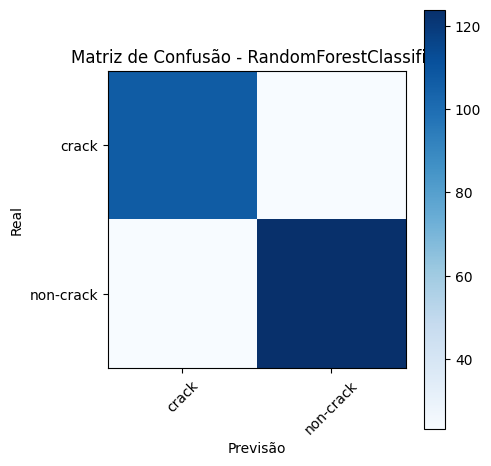